## Função auxiliar para capturar uma imagem da camera local

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.7):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      // await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Definições para o Mecanismo de Atenção Visual Bottom Up





A convolução de uma família de filtros de Gabor sobre uma imagem permite extrair características de baixo nível, incluindo bordas em diferentes orientações:

![alt text](http://drive.google.com/uc?export=view&id=1qnuUq0sETXrmHBpVHNGMH_eOooafr24C)

![alt text](http://drive.google.com/uc?export=view&id=1KSNskaFtDEwj6aqhWfVNGMlarbiUKMJ9)

Além das características de cor, orientação e intensidade vistas em sala de aula, o mecanismo de atenção visual implementado neste código também considera características de movimento via fluxo óptico. 

In [ ]:
#-------------------------------------------------------------------------------
# Name:        pySaliencyMapDefs
# Purpose:     Definitions for class pySaliencyMap
#
# Author:      Akisato Kimura <akisato@ieee.org>
#
# Created:     April 24, 2014
# Copyright:   (c) Akisato Kimura 2014-
# Licence:     All rights reserved
#-------------------------------------------------------------------------------

# parameters for computing optical flows using the Gunner Farneback's algorithm
farne_pyr_scale = 0.5
farne_levels = 3
farne_winsize = 15
farne_iterations = 3
farne_poly_n = 5
farne_poly_sigma = 1.2
farne_flags = 0

# parameters for detecting local maxima
default_step_local = 16

# feature weights
weight_intensity   = 0.30
weight_color       = 0.30
weight_orientation = 0.20
weight_motion      = 0.20

# coefficients of Gabor filters
GaborKernel_0 = [\
    [ 1.85212E-06, 1.28181E-05, -0.000350433, -0.000136537, 0.002010422, -0.000136537, -0.000350433, 1.28181E-05, 1.85212E-06 ],\
    [ 2.80209E-05, 0.000193926, -0.005301717, -0.002065674, 0.030415784, -0.002065674, -0.005301717, 0.000193926, 2.80209E-05 ],\
    [ 0.000195076, 0.001350077, -0.036909595, -0.014380852, 0.211749204, -0.014380852, -0.036909595, 0.001350077, 0.000195076 ],\
    [ 0.000624940, 0.004325061, -0.118242318, -0.046070008, 0.678352526, -0.046070008, -0.118242318, 0.004325061, 0.000624940 ],\
    [ 0.000921261, 0.006375831, -0.174308068, -0.067914552, 1.000000000, -0.067914552, -0.174308068, 0.006375831, 0.000921261 ],\
    [ 0.000624940, 0.004325061, -0.118242318, -0.046070008, 0.678352526, -0.046070008, -0.118242318, 0.004325061, 0.000624940 ],\
    [ 0.000195076, 0.001350077, -0.036909595, -0.014380852, 0.211749204, -0.014380852, -0.036909595, 0.001350077, 0.000195076 ],\
    [ 2.80209E-05, 0.000193926, -0.005301717, -0.002065674, 0.030415784, -0.002065674, -0.005301717, 0.000193926, 2.80209E-05 ],\
    [ 1.85212E-06, 1.28181E-05, -0.000350433, -0.000136537, 0.002010422, -0.000136537, -0.000350433, 1.28181E-05, 1.85212E-06 ]\
]
GaborKernel_45 = [\
    [  4.04180E-06,  2.25320E-05, -0.000279806, -0.001028923,  3.79931E-05,  0.000744712,  0.000132863, -9.04408E-06, -1.01551E-06 ],\
    [  2.25320E-05,  0.000925120,  0.002373205, -0.013561362, -0.022947700,  0.000389916,  0.003516954,  0.000288732, -9.04408E-06 ],\
    [ -0.000279806,  0.002373205,  0.044837725,  0.052928748, -0.139178011, -0.108372072,  0.000847346,  0.003516954,  0.000132863 ],\
    [ -0.001028923, -0.013561362,  0.052928748,  0.460162150,  0.249959607, -0.302454279, -0.108372072,  0.000389916,  0.000744712 ],\
    [  3.79931E-05, -0.022947700, -0.139178011,  0.249959607,  1.000000000,  0.249959607, -0.139178011, -0.022947700,  3.79931E-05 ],\
    [  0.000744712,  0.003899160, -0.108372072, -0.302454279,  0.249959607,  0.460162150,  0.052928748, -0.013561362, -0.001028923 ],\
    [  0.000132863,  0.003516954,  0.000847346, -0.108372072, -0.139178011,  0.052928748,  0.044837725,  0.002373205, -0.000279806 ],\
    [ -9.04408E-06,  0.000288732,  0.003516954,  0.000389916, -0.022947700, -0.013561362,  0.002373205,  0.000925120,  2.25320E-05 ],\
    [ -1.01551E-06, -9.04408E-06,  0.000132863,  0.000744712,  3.79931E-05, -0.001028923, -0.000279806,  2.25320E-05,  4.04180E-06 ]\
]
GaborKernel_90 = [\
    [  1.85212E-06,  2.80209E-05,  0.000195076,  0.000624940,  0.000921261,  0.000624940,  0.000195076,  2.80209E-05,  1.85212E-06 ],\
    [  1.28181E-05,  0.000193926,  0.001350077,  0.004325061,  0.006375831,  0.004325061,  0.001350077,  0.000193926,  1.28181E-05 ],\
    [ -0.000350433, -0.005301717, -0.036909595, -0.118242318, -0.174308068, -0.118242318, -0.036909595, -0.005301717, -0.000350433 ],\
    [ -0.000136537, -0.002065674, -0.014380852, -0.046070008, -0.067914552, -0.046070008, -0.014380852, -0.002065674, -0.000136537 ],\
    [  0.002010422,  0.030415784,  0.211749204,  0.678352526,  1.000000000,  0.678352526,  0.211749204,  0.030415784,  0.002010422 ],\
    [ -0.000136537, -0.002065674, -0.014380852, -0.046070008, -0.067914552, -0.046070008, -0.014380852, -0.002065674, -0.000136537 ],\
    [ -0.000350433, -0.005301717, -0.036909595, -0.118242318, -0.174308068, -0.118242318, -0.036909595, -0.005301717, -0.000350433 ],\
    [  1.28181E-05,  0.000193926,  0.001350077,  0.004325061,  0.006375831,  0.004325061,  0.001350077,  0.000193926,  1.28181E-05 ],\
    [  1.85212E-06,  2.80209E-05,  0.000195076,  0.000624940,  0.000921261,  0.000624940,  0.000195076,  2.80209E-05,  1.85212E-06 ]
]
GaborKernel_135 = [\
    [ -1.01551E-06, -9.04408E-06,  0.000132863,  0.000744712,  3.79931E-05, -0.001028923, -0.000279806, 2.2532E-05, 4.0418E-06 ],\
    [ -9.04408E-06,  0.000288732,  0.003516954,  0.000389916, -0.022947700, -0.013561362, 0.002373205, 0.00092512, 2.2532E-05 ],\
    [  0.000132863,  0.003516954,  0.000847346, -0.108372072, -0.139178011, 0.052928748, 0.044837725, 0.002373205, -0.000279806 ],\
    [  0.000744712,  0.000389916, -0.108372072, -0.302454279,  0.249959607, 0.46016215, 0.052928748, -0.013561362, -0.001028923 ],\
    [  3.79931E-05, -0.022947700, -0.139178011,  0.249959607,  1.000000000, 0.249959607, -0.139178011, -0.0229477, 3.79931E-05 ],\
    [ -0.001028923, -0.013561362,  0.052928748,  0.460162150,  0.249959607, -0.302454279, -0.108372072, 0.000389916, 0.000744712 ],\
    [ -0.000279806,  0.002373205,  0.044837725,  0.052928748, -0.139178011, -0.108372072, 0.000847346, 0.003516954, 0.000132863 ],\
    [  2.25320E-05,  0.000925120,  0.002373205, -0.013561362, -0.022947700, 0.000389916, 0.003516954, 0.000288732, -9.04408E-06 ],\
    [  4.04180E-06,  2.25320E-05, -0.000279806, -0.001028923,  3.79931E-05 , 0.000744712, 0.000132863, -9.04408E-06, -1.01551E-06 ]\
]

## Implementação do Mecanismo de Atenção Visual Bottom Up 
(proposto por Itti e Koch)

In [ ]:
#-------------------------------------------------------------------------------
# Name:        pySaliencyMap
# Purpose:     Extracting a saliency map from a single still image
#
# Author:      Akisato Kimura <akisato@ieee.org>
#
# Created:     April 24, 2014
# Copyright:   (c) Akisato Kimura 2014-
# Licence:     All rights reserved
#-------------------------------------------------------------------------------

import cv2
import numpy as np
#import pySaliencyMapDefs

class pySaliencyMap:
    # initialization
    def __init__(self, width, height):
        self.width  = width
        self.height = height
        self.prev_frame = None
        self.SM = None
        self.GaborKernel0   = np.array(GaborKernel_0)
        self.GaborKernel45  = np.array(GaborKernel_45)
        self.GaborKernel90  = np.array(GaborKernel_90)
        self.GaborKernel135 = np.array(GaborKernel_135)

    # extracting color channels
    def SMExtractRGBI(self, inputImage):
        # convert scale of array elements
        src = np.float32(inputImage) * 1./255
        # split
        (B, G, R) = cv2.split(src)
        # extract an intensity image
        I= cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        # return
        return R, G, B, I

    # feature maps
    ## constructing a Gaussian pyramid
    def FMCreateGaussianPyr(self, src):
        dst = list()
        dst.append(src)
        for i in range(1,9):
            nowdst = cv2.pyrDown(dst[i-1])
            dst.append(nowdst)
        return dst
    ## taking center-surround differences
    def FMCenterSurroundDiff(self, GaussianMaps):
        dst = list()
        for s in range(2,5):
            now_size = GaussianMaps[s].shape
            now_size = (now_size[1], now_size[0])  ## (width, height)
            tmp = cv2.resize(GaussianMaps[s+3], now_size, interpolation=cv2.INTER_LINEAR)
            nowdst = cv2.absdiff(GaussianMaps[s], tmp)
            dst.append(nowdst)
            tmp = cv2.resize(GaussianMaps[s+4], now_size, interpolation=cv2.INTER_LINEAR)
            nowdst = cv2.absdiff(GaussianMaps[s], tmp)
            dst.append(nowdst)
        return dst
    ## constructing a Gaussian pyramid + taking center-surround differences
    def FMGaussianPyrCSD(self, src):
        GaussianMaps = self.FMCreateGaussianPyr(src)
        dst = self.FMCenterSurroundDiff(GaussianMaps)
        return dst
    ## intensity feature maps
    def IFMGetFM(self, I):
        return self.FMGaussianPyrCSD(I)
    ## color feature maps
    def CFMGetFM(self, R, G, B):
        # max(R,G,B)
        tmp1 = cv2.max(R, G)
        RGBMax = cv2.max(B, tmp1)
        RGBMax[RGBMax <= 0] = 0.0001    # prevent dividing by 0
        # min(R,G)
        RGMin = cv2.min(R, G)
        # RG = (R-G)/max(R,G,B)
        RG = (R - G) / RGBMax
        # BY = (B-min(R,G)/max(R,G,B)
        BY = (B - RGMin) / RGBMax
        # clamp nagative values to 0
        RG[RG < 0] = 0
        BY[BY < 0] = 0
        # obtain feature maps in the same way as intensity
        RGFM = self.FMGaussianPyrCSD(RG)
        BYFM = self.FMGaussianPyrCSD(BY)
        # return
        return RGFM, BYFM
    ## orientation feature maps
    def OFMGetFM(self, src):
        # creating a Gaussian pyramid
        GaussianI = self.FMCreateGaussianPyr(src)
        # convoluting a Gabor filter with an intensity image to extract oriemtation features
        GaborOutput0   = [ np.empty((1,1)), np.empty((1,1)) ]  # dummy data: any kinds of np.array()s are OK
        GaborOutput45  = [ np.empty((1,1)), np.empty((1,1)) ]
        GaborOutput90  = [ np.empty((1,1)), np.empty((1,1)) ]
        GaborOutput135 = [ np.empty((1,1)), np.empty((1,1)) ]
        for j in range(2,9):
            GaborOutput0.append(   cv2.filter2D(GaussianI[j], cv2.CV_32F, self.GaborKernel0) )
            GaborOutput45.append(  cv2.filter2D(GaussianI[j], cv2.CV_32F, self.GaborKernel45) )
            GaborOutput90.append(  cv2.filter2D(GaussianI[j], cv2.CV_32F, self.GaborKernel90) )
            GaborOutput135.append( cv2.filter2D(GaussianI[j], cv2.CV_32F, self.GaborKernel135) )
        # calculating center-surround differences for every oriantation
        CSD0   = self.FMCenterSurroundDiff(GaborOutput0)
        CSD45  = self.FMCenterSurroundDiff(GaborOutput45)
        CSD90  = self.FMCenterSurroundDiff(GaborOutput90)
        CSD135 = self.FMCenterSurroundDiff(GaborOutput135)
        # concatenate
        dst = list(CSD0)
        dst.extend(CSD45)
        dst.extend(CSD90)
        dst.extend(CSD135)
        # return
        return dst
    ## motion feature maps
    def MFMGetFM(self, src):
        # convert scale
        I8U = np.uint8(255 * src)
        cv2.waitKey(10)
        # calculating optical flows
        if self.prev_frame is not None:
            farne_pyr_scale= farne_pyr_scale
            farne_levels = farne_levels
            farne_winsize = farne_winsize
            farne_iterations = farne_iterations
            farne_poly_n = farne_poly_n
            farne_poly_sigma = farne_poly_sigma
            farne_flags = farne_flags
            flow = cv2.calcOpticalFlowFarneback(\
                prev = self.prev_frame, \
                next = I8U, \
                pyr_scale = farne_pyr_scale, \
                levels = farne_levels, \
                winsize = farne_winsize, \
                iterations = farne_iterations, \
                poly_n = farne_poly_n, \
                poly_sigma = farne_poly_sigma, \
                flags = farne_flags, \
                flow = None \
            )
            flowx = flow[...,0]
            flowy = flow[...,1]
        else:
            flowx = np.zeros(I8U.shape)
            flowy = np.zeros(I8U.shape)
        # create Gaussian pyramids
        dst_x = self.FMGaussianPyrCSD(flowx)
        dst_y = self.FMGaussianPyrCSD(flowy)
        # update the current frame
        self.prev_frame = np.uint8(I8U)
        # return
        return dst_x, dst_y

    # conspicuity maps
    ## standard range normalization
    def SMRangeNormalize(self, src):
        minn, maxx, dummy1, dummy2 = cv2.minMaxLoc(src)
        if maxx!=minn:
            dst = src/(maxx-minn) + minn/(minn-maxx)
        else:
            dst = src - minn
        return dst
    ## computing an average of local maxima
    def SMAvgLocalMax(self, src):
        # size
        stepsize = default_step_local
        width = src.shape[1]
        height = src.shape[0]
        # find local maxima
        numlocal = 0
        lmaxmean = 0
        for y in range(0, height-stepsize, stepsize):
            for x in range(0, width-stepsize, stepsize):
                localimg = src[y:y+stepsize, x:x+stepsize]
                lmin, lmax, dummy1, dummy2 = cv2.minMaxLoc(localimg)
                lmaxmean += lmax
                numlocal += 1
        # averaging over all the local regions
        return lmaxmean / numlocal
    ## normalization specific for the saliency map model
    def SMNormalization(self, src):
        dst = self.SMRangeNormalize(src)
        lmaxmean = self.SMAvgLocalMax(dst)
        normcoeff = (1-lmaxmean)*(1-lmaxmean)
        return dst * normcoeff
    ## normalizing feature maps
    def normalizeFeatureMaps(self, FM):
        NFM = list()
        for i in range(0,6):
            normalizedImage = self.SMNormalization(FM[i])
            nownfm = cv2.resize(normalizedImage, (self.width, self.height), interpolation=cv2.INTER_LINEAR)
            NFM.append(nownfm)
        return NFM
    ## intensity conspicuity map
    def ICMGetCM(self, IFM):
        NIFM = self.normalizeFeatureMaps(IFM)
        ICM = sum(NIFM)
        return ICM
    ## color conspicuity map
    def CCMGetCM(self, CFM_RG, CFM_BY):
        # extracting a conspicuity map for every color opponent pair
        CCM_RG = self.ICMGetCM(CFM_RG)
        CCM_BY = self.ICMGetCM(CFM_BY)
        # merge
        CCM = CCM_RG + CCM_BY
        # return
        return CCM
    ## orientation conspicuity map
    def OCMGetCM(self, OFM):
        OCM = np.zeros((self.height, self.width))
        for i in range (0,4):
            # slicing
            nowofm = OFM[i*6:(i+1)*6]  # angle = i*45
            # extracting a conspicuity map for every angle
            NOFM = self.ICMGetCM(nowofm)
            # normalize
            NOFM2 = self.SMNormalization(NOFM)
            # accumulate
            OCM += NOFM2
        return OCM
    ## motion conspicuity map
    def MCMGetCM(self, MFM_X, MFM_Y):
        return self.CCMGetCM(MFM_X, MFM_Y)

    # core
    def SMGetSM(self, src):
        # definitions
        size = src.shape
        width  = size[1]
        height = size[0]
        # check
#        if(width != self.width or height != self.height):
#            sys.exit("size mismatch")
        # extracting individual color channels
        R, G, B, I = self.SMExtractRGBI(src)
        # extracting feature maps
        IFM = self.IFMGetFM(I)
        CFM_RG, CFM_BY = self.CFMGetFM(R, G, B)
        OFM = self.OFMGetFM(I)
        MFM_X, MFM_Y = self.MFMGetFM(I)
        # extracting conspicuity maps
        ICM = self.ICMGetCM(IFM)
        CCM = self.CCMGetCM(CFM_RG, CFM_BY)
        OCM = self.OCMGetCM(OFM)
        MCM = self.MCMGetCM(MFM_X, MFM_Y)
        # adding all the conspicuity maps to form a saliency map
        wi = weight_intensity
        wc = weight_color
        wo = weight_orientation
        wm = weight_motion
        SMMat = wi*ICM + wc*CCM + wo*OCM + wm*MCM
        # normalize
        normalizedSM = self.SMRangeNormalize(SMMat)
        normalizedSM2 = normalizedSM.astype(np.float32)
        smoothedSM = cv2.bilateralFilter(normalizedSM2, 7, 3, 1.55)
        self.SM = cv2.resize(smoothedSM, (width,height), interpolation=cv2.INTER_NEAREST)
        # return
        return self.SM

    def SMGetBinarizedSM(self, src):
        # get a saliency map
        if self.SM is None:
            self.SM = self.SMGetSM(src)
        # convert scale
        SM_I8U = np.uint8(255 * self.SM)
        # binarize
        thresh, binarized_SM = cv2.threshold(SM_I8U, thresh=0, maxval=255, type=cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return binarized_SM

    def SMGetSalientRegion(self, src):
        # get a binarized saliency map
        binarized_SM = self.SMGetBinarizedSM(src)
        # GrabCut
        img = src.copy()
        mask =  np.where((binarized_SM!=0), cv2.GC_PR_FGD, cv2.GC_PR_BGD).astype('uint8')
        bgdmodel = np.zeros((1,65),np.float64)
        fgdmodel = np.zeros((1,65),np.float64)
        rect = (0,0,1,1)  # dummy
        iterCount = 1
        cv2.grabCut(img, mask=mask, rect=rect, bgdModel=bgdmodel, fgdModel=fgdmodel, iterCount=iterCount, mode=cv2.GC_INIT_WITH_MASK)
        # post-processing
        mask_out = np.where((mask==cv2.GC_FGD) + (mask==cv2.GC_PR_FGD), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img,img,mask=mask_out)
        return output


## Testando o mecanismo de atenção em imagens da Internet

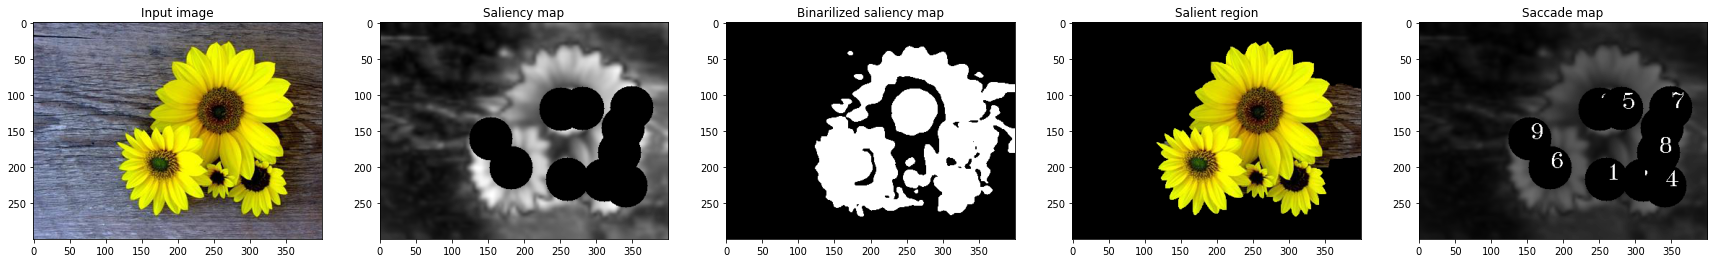

In [ ]:
#-------------------------------------------------------------------------------
# Name:        main
# Purpose:     Testing the package pySaliencyMap
#
# Author:      Akisato Kimura <akisato@ieee.org>
#
# Created:     May 4, 2014
# Copyright:   (c) Akisato Kimura 2014-
# Licence:     All rights reserved
#-------------------------------------------------------------------------------

import cv2
import matplotlib.pyplot as plt
from skimage import io

# main
if __name__ == '__main__':
    # read
    img = io.imread('https://github.com/akisatok/pySaliencyMap/raw/master/test3.jpg')
    #img = io.imread('https://cdn.shopify.com/s/files/1/1865/1389/collections/Tranquility_2000x.progressive.jpg?v=1502724928')
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #cv2.imread()
    # initialize
    imgsize = img.shape
    img_width  = imgsize[1]
    img_height = imgsize[0]
    sm = pySaliencyMap(img_width, img_height)
    # computation
    saliency_map = sm.SMGetSM(img)
    binarized_map = sm.SMGetBinarizedSM(img)
    salient_region = sm.SMGetSalientRegion(img)
    # Creating a saccade map (Herman)
    saccade_map=saliency_map.copy()
    for i in range(10):
      (_, _, _, maxLoc) = cv2.minMaxLoc(saliency_map)
      cv2.circle(saliency_map, maxLoc, 30, (0, 0, 0), -1)
      cv2.circle(saccade_map, maxLoc, 30, (0, 0, 0), -1)
      cv2.putText(saccade_map,str(i), maxLoc, cv2.FONT_HERSHEY_TRIPLEX, 1, (1,1,1), 1, cv2.LINE_AA);
      
    # visualize
    plt.figure(figsize=(30, 10))
    plt.subplot(1,5,1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Input image')
    plt.subplot(1,5,2), plt.imshow(saliency_map, 'gray')
    plt.title('Saliency map')
    plt.subplot(1,5,3), plt.imshow(binarized_map, 'gray')
    plt.title('Binarilized saliency map')
    plt.subplot(1,5,4), plt.imshow(cv2.cvtColor(salient_region, cv2.COLOR_BGR2RGB))
    plt.title('Salient region')
    plt.subplot(1,5,5), plt.imshow(saccade_map, 'gray')
    plt.title('Saccade map')

    plt.show()

## Testando o mecanismo de atenção com imagens da camera local

In [ ]:
#-------------------------------------------------------------------------------
# Name:        main_webcam
# Purpose:     Testing the package pySaliencyMap with your own webcams
#
# Author:      Akisato Kimura <akisato@ieee.org>
#
# Created:     May 14, 2016
# Copyright:   (c) Akisato Kimura 2016-
# Licence:     All rights reserved
#-------------------------------------------------------------------------------

import cv2
import matplotlib.pyplot as plt
from IPython.display import Image
from google.colab.patches import cv2_imshow

# main
try:
   filename = take_photo()
   print('Saved to {}'.format(filename))
   # Show the image which was just taken.
   #display(Image(filename))
except Exception as err:
   # Errors will be thrown if the user does not have a webcam or if they do not
   # grant the page permission to access it.
   print(str(err))

frame = cv2.imread(filename)

# initialize
frame_size = frame.shape
frame_width  = frame_size[1]
frame_height = frame_size[0]
sm = pySaliencyMap(frame_width, frame_height)
# computation
saliency_map = sm.SMGetSM(frame) 
salient_region = sm.SMGetSalientRegion(frame)

cv2_imshow(frame)
cv2_imshow(saliency_map*255)
cv2_imshow(salient_region)


## Agora é a sua vez
Implemente uma função para computar um percentual de saliência de uma imagem img a partir do mapa de saliência binarizado, utilizando a seguinte fórmula:

Percentual_saliencia = soma_pixels_nao_nulos(sm.SMGetBinarizedSM(img))/(largura * altura)

Realize testes  de sua função sobre as seguintes imagens e comente qual a relação entre o percentual de saliência e as características das imagens. Deixe os códigos dentro do notebook de resposta.

https://www.researchgate.net/profile/Henning_Tjaden/publication/320805072/figure/fig2/AS:631649343655960@1527608347292/Estimating-the-pose-of-a-heterogenous-object-in-a-cluttered-scene-under-strong-occlusions.png

http://starofmysore.com/wp-content/uploads/2017/02/bangalore-mysore-traffic.jpg

https://cdn.shopify.com/s/files/1/1865/1389/collections/Tranquility_2000x.progressive.jpg?v=1502724928

https://images.pexels.com/photos/2166711/pexels-photo-2166711.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500

## Atividade Bonus 1
Corrija a inibição de retorno (incorreta) que não deveria existir no Mapa de Saliência do exemplo das flores amarelas.


In [ ]:
#Percentual_saliencia = soma_pixels_nao_nulos(sm.SMGetBinarizedSM(img))/(largura * altura)
from skimage import io

def percentual_saliencia(img):

  img = io.imread(img)
  img_size = img.shape
  img_width  = img_size[1]
  img_height = img_size[0]
  sm = pySaliencyMap(img_width, img_height)
  binary = sm.SMGetBinarizedSM(img)

  nao_nulos = 0
  for lista in binary:
    for pixel in lista:
      if(pixel != 0):    
        nao_nulos = nao_nulos + 1

  return nao_nulos / (img_height * img_width)


#Testes
print(percentual_saliencia("https://www.researchgate.net/profile/Henning_Tjaden/publication/320805072/figure/fig2/AS:631649343655960@1527608347292/Estimating-the-pose-of-a-heterogenous-object-in-a-cluttered-scene-under-strong-occlusions.png"))
print(percentual_saliencia("https://docs.google.com/uc?id=1sBxd7b-1oHlidA81-rucxGvTdCd0qqQ5"))
print(percentual_saliencia("https://cdn.shopify.com/s/files/1/1865/1389/collections/Tranquility_2000x.progressive.jpg?v=1502724928"))
print(percentual_saliencia("https://docs.google.com/uc?id=1gyKa43IQvV9OOfLWX10LyVsMlkncqAy-"))

0.296014404296875
0.13135928143712575
0.105405
0.31333912037037037


As imagens que possuem muitos objetos como: foto do trânsito na índia e a mesa cheio de objetos obtiveram uma maior percentual de saliência, já as outras duas fotos obtiveram um menor percentual de saliência, é interessante observar que ambas possuem água.